In [ ]:
%%capture
# movie review text classification
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# !pip3 install tensorflow_hub tensorflow_datasets matplotlib
# ! clear
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

In [2]:
%%capture
# load imdb_reviews data with tfds
train_data, test_data = tfds.load(name="imdb_reviews",
                        split=["train","test"], batch_size=-1,
                        as_supervised=True,
                        data_dir="./data/imdb_reviews",download=True);

2022-06-15 02:30:34.710899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# split dataset as train, test, val
train_x, train_y = tfds.as_numpy(train_data)
test_x, test_y = tfds.as_numpy(test_data)

val_x, val_y = train_x[:10000], train_y[:10000]
train_x, train_y = train_x[10000:], train_y[10000:]

print(len(train_x), len(train_y),
    len(test_x), len(test_y),
    len(val_x), len(val_y))

# sample
print(train_x[0][:30], train_y[0]) # label == 0 neg, 1 pos

15000 15000 25000 25000 10000 10000
b'Although released among a floc' 1


In [4]:
# create keras model with ...
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], 
    dtype=tf.string, trainable=True)
# hub_layer(train_x[:1])

In [5]:
# full model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer="adam",
    # used for binary classification model
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name="accuracy")])

In [7]:
history = model.fit(
    train_x, train_y, epochs=40, batch_size=512,
    validation_data = (val_x, val_y), verbose=1
)
results = model.evaluate(test_x, test_y) 
print(results) # loss, accuracy

Epoch 1/40
30/30 [==============================] - 15s 485ms/step - loss: 0.6671 - accuracy: 0.5955 - val_loss: 0.6083 - val_accuracy: 0.7186
Epoch 2/40
30/30 [==============================] - 13s 439ms/step - loss: 0.5470 - accuracy: 0.7739 - val_loss: 0.5049 - val_accuracy: 0.7862
Epoch 3/40
30/30 [==============================] - 13s 446ms/step - loss: 0.4130 - accuracy: 0.8512 - val_loss: 0.4018 - val_accuracy: 0.8387
Epoch 4/40
30/30 [==============================] - 13s 433ms/step - loss: 0.2937 - accuracy: 0.9045 - val_loss: 0.3399 - val_accuracy: 0.8602
Epoch 5/40
30/30 [==============================] - 13s 451ms/step - loss: 0.2127 - accuracy: 0.9331 - val_loss: 0.3131 - val_accuracy: 0.8701
Epoch 6/40
30/30 [==============================] - 15s 491ms/step - loss: 0.1551 - accuracy: 0.9563 - val_loss: 0.3039 - val_accuracy: 0.8727
Epoch 7/40
30/30 [==============================] - 13s 444ms/step - loss: 0.1131 - accuracy: 0.9723 - val_loss: 0.3004 - val_accuracy: 0.8748

In [8]:
hist_dict = history.history
# training acc, loss
acc = hist_dict["accuracy"]
loss = hist_dict["loss"]
# validation acc, loss
val_acc = hist_dict["val_loss"]
val_loss = hist_dict["val_accuracy"]

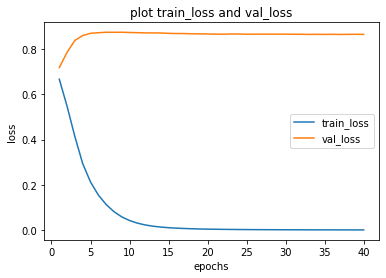

In [9]:
# plot loss graph
epochs = range(1,len(acc)+1)
plt.title("plot train_loss and val_loss")
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
# loss decreases with each epoch, acc increases
# val loss, acc shows overfitting after ~20 epochs

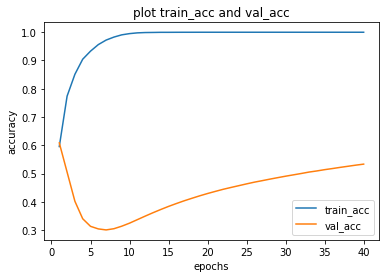

In [10]:
# plot accuracy graph
epochs = range(1,len(acc)+1)
plt.title("plot train_acc and val_acc")
plt.plot(epochs, acc, label="train_acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()